In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/df_stats_cotes_teams.csv', index_col = 0)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

prediction = pd.read_csv('/content/drive/MyDrive/dataset/dataset_moyennes_matchs.csv', index_col = 0)
prediction['date'] = pd.to_datetime(prediction['date'], dayfirst=True)

In [ ]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1519
Data columns (total 232 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   match_id                          int64         
 1   home_team_id                      int64         
 2   home_team_name                    object        
 3   home_team_rating                  float64       
 4   date                              datetime64[ns]
 5   time                              object        
 6   season                            object        
 7   home_att_goal_low_left            int64         
 8   home_won_contest                  float64       
 9   home_possession_percentage        float64       
 10  home_total_throws                 float64       
 11  home_att_miss_high_left           float64       
 12  home_blocked_scoring_att          float64       
 13  home_total_scoring_att            float64       
 14  home_att_sv_low_left   

In [ ]:
surebet = df.loc[1/df['BestH'] + 1/df['BestD'] + 1/df['BestA'] < 1,['season', 'date', 'home_team_name', 'away_team_name', 'BestH', 'BestD', 'BestA', 'FTR']]
surebet['MiseH'] = round((100/surebet['BestH'] + 100/surebet['BestD'] + 100/surebet['BestA']) / surebet['BestH'], 2)
surebet['MiseD'] = round((100/surebet['BestH'] + 100/surebet['BestD'] + 100/surebet['BestA']) / surebet['BestD'], 2)
surebet['MiseA'] = round((100/surebet['BestH'] + 100/surebet['BestD'] + 100/surebet['BestA']) / surebet['BestA'], 2)
surebet['Mise'] = surebet['MiseH'] + surebet['MiseD'] + surebet['MiseA']
surebet['MiseH'] = round(100 * surebet['MiseH'] / surebet['Mise'], 2)
surebet['MiseD'] = round(100 * surebet['MiseD'] / surebet['Mise'], 2)
surebet['MiseA'] = round(100 * surebet['MiseA'] / surebet['Mise'], 2)
surebet['Mise'] = surebet['MiseH'] + surebet['MiseD'] + surebet['MiseA']
surebet['GainH'] = [round(-v, 2) if u != 'H' else round(v * (w - 1), 2) for (u, v, w) in zip(surebet['FTR'], surebet['MiseH'], surebet['BestH'])]
surebet['GainD'] = [round(-v, 2) if u != 'D' else round(v * (w - 1), 2) for (u, v, w) in zip(surebet['FTR'], surebet['MiseD'], surebet['BestD'])]
surebet['GainA'] = [round(-v, 2) if u != 'A' else round(v * (w - 1), 2) for (u, v, w) in zip(surebet['FTR'], surebet['MiseA'], surebet['BestA'])]
surebet['Gain'] = surebet['GainH'] + surebet['GainD'] + surebet['GainA']

surebet.head()

,season,date,home_team_name,away_team_name,BestH,BestD,BestA,FTR,MiseH,MiseD,MiseA,Mise,GainH,GainD,GainA,Gain
0,2014-2015,2014-08-16,Arsenal,Crystal Palace,1.30,6.50,15.00,H,77.72,15.55,6.74,100.01,23.32,-15.55,-6.74,1.03
2,2014-2015,2014-08-16,Manchester United,Swansea,1.45,5.20,11.00,A,70.89,19.77,9.34,100.00,-70.89,-19.77,93.40,2.74
3,2014-2015,2014-08-16,Queens Park Rangers,Hull,2.60,3.30,3.59,A,39.81,31.37,28.83,100.01,-39.81,-31.37,74.67,3.49
4,2014-2015,2014-08-16,Stoke,Aston Villa,2.01,3.50,4.75,A,50.07,28.75,21.18,100.00,-50.07,-28.75,79.42,0.60
5,2014-2015,2014-08-16,West Bromwich Albion,Sunderland,2.30,3.42,4.03,D,44.58,29.98,25.44,100.00,-44.58,72.55,-25.44,2.53


In [ ]:
def previous_results(id):

  df_home_last_home_results = pd.DataFrame()
  df_home_last_results = pd.DataFrame()
  df_away_last_away_results = pd.DataFrame()
  df_away_last_results = pd.DataFrame()
  df_last_results = pd.DataFrame()

  # récupération du nom des équipes
  home = list(df[df['match_id'] == id]['home_team_name'])[0]
  away = list(df[df['match_id'] == id]['away_team_name'])[0]
  season = list(df[df['match_id'] == id]['season'])[0]
  date = list(df[df['match_id'] == id]['date'])[0]

  #création des dataframes home
  home_last_home_results = df[(df['home_team_name'] == home) & (df['date'] < date)][:]
  home_last_results = df[((df['home_team_name'] == home) | (df['away_team_name'] == home)) & (df['date'] < date)][:]

  #création des dataframes away
  away_last_away_results = df[(df['away_team_name'] == away) & (df['date'] < date)][:]
  away_last_results = df[((df['home_team_name'] == away) | (df['away_team_name'] == away)) & (df['date'] < date)][:]

  #création des dataframes confrontation
  last_results = df[(((df['home_team_name'] == home) & (df['away_team_name'] == away)) | ((df['home_team_name'] == away) & (df['away_team_name'] == home))) & (df['date'] < date)][:]

  #selection des n derniers matchs (pour home_last_results et away_last_results seulement)
  home_last_home_results = home_last_home_results.sort_values(by = ['date'], ascending = False)
  home_last_results = home_last_results.sort_values(by = ['date'], ascending = False)
  away_last_away_results = away_last_away_results.sort_values(by = ['date'], ascending = False)
  away_last_results = away_last_results.sort_values(by = ['date'], ascending = False)
  last_results = last_results.sort_values(by = ['date'], ascending = False)

  return home_last_home_results, home_last_results, away_last_away_results, away_last_results, last_results

In [ ]:
team = ['home', 'away']
plt.figure(figsize=(25, 10));
data = {i + '_comparison' :pd.DataFrame() for i in team}

for i in range(2):
  
  comparison = pd.DataFrame(columns = ['match_id', team[i] + '_goals_predicted', team[i] + '_goals_scored'])

  for match_id in prediction['match_id']:

    a, b, c, d, e = previous_results(match_id)
    train = pd.concat([a, b, c, d, e]).drop_duplicates()
  
    #plt.subplot(1, 2, i + 1);
    #sns.heatmap(train[[team[(i + 0) % 2] + '_midfielder_player_rating', team[(i + 0) % 2] + '_forward_player_rating', team[(i + 0) % 2] + '_ontarget_scoring_att', team [(i + 1) % 2] + '_goalkeeper_player_rating', team[(i + 1) % 2] + '_defender_player_rating', team[(i + 1) % 2] +'_midfielder_player_rating', 'FT' + team[i].upper()[0] + 'G']].corr(), annot=True);

    features = train[[team[(i + 0) % 2] + '_midfielder_player_rating', team[(i + 0) % 2] + '_forward_player_rating', team[(i + 0) % 2] + '_ontarget_scoring_att', team[(i + 1) % 2] + '_goalkeeper_player_rating', team[(i + 1) % 2] + '_defender_player_rating', team[(i + 1) % 2] + '_midfielder_player_rating']]
    target = train['FT' + team[i].upper()[0] + 'G']

    match = prediction.loc[prediction['match_id'] == match_id, [team[(i + 0) % 2] + '_midfielder_player_rating', team[(i + 0) % 2] + '_forward_player_rating', team[(i + 0) % 2] + '_ontarget_scoring_att', team[(i + 1) % 2] + '_goalkeeper_player_rating', team[(i + 1) % 2] + '_defender_player_rating', team[(i + 1) % 2] + '_midfielder_player_rating']]
  
    #Modèle de Poisson
    goal_model = sm.GLM(target, features, family=sm.families.Poisson()).fit();
    
    comparison.index.append(pd.Index([len(comparison)]))
    comparison.loc[len(comparison), 'match_id'] = match_id
    comparison.loc[len(comparison) - 1, team[i] + '_goals_predicted'] = list(round(goal_model.predict(match)))[0]
    comparison.loc[len(comparison) - 1, team[i] + '_goals_scored'] = list(df.loc[df['match_id'] == match_id, 'FT' + team[i].upper()[0] + 'G'])[0]
  
  data[team[(i + 0) % 2] + '_comparison'] = comparison
  display(pd.crosstab(comparison[team[i] + '_goals_predicted'], comparison[team[i] + '_goals_scored']))
  print(f"Taux de bonne prédiction : {100 * comparison[comparison[team[i] + '_goals_scored'] == comparison[team[i] + '_goals_predicted']].count()[0] / len(comparison): .2f}%")


home_goals_scored,0,1,2,3,4,5,6,7,8
home_goals_predicted,,,,,,,,,
0.0,5,16,9,2,4,0,0,0,1
1.0,270,329,241,113,42,13,6,0,0
2.0,49,102,74,53,20,13,3,1,0
3.0,5,11,20,8,7,2,0,0,0
4.0,1,2,2,1,0,0,0,0,0


Taux de bonne prédiction :  29.19%


away_goals_scored,0,1,2,3,4,5,6,7
away_goals_predicted,,,,,,,,
0.0,96,84,36,16,7,0,0,0
1.0,365,340,204,87,39,5,2,0
2.0,27,50,28,14,4,3,0,1
3.0,2,4,5,3,0,0,1,0
4.0,0,1,0,1,0,0,0,0


Taux de bonne prédiction :  32.77%


<Figure size 1800x720 with 0 Axes>

PredictedResult,A,D,H
RealResult,,,
A,67,248,104
D,31,195,124
H,50,317,289


Taux de bonne prédiction :  38.67%
Gain total : 652.18€
Gain en pourcentage : 45.77%


OddResult,A,D,H
RealResult,,,
A,129,1,289
D,109,0,241
H,201,1,454


Taux de bonne prédiction :  40.91%
Gain total : -274.78€
Gain en pourcentage : -19.28%


PredictedGoal,<2.5,>2.5
RealGoal,,
<2.5,488,199
>2.5,506,232


Taux de bonne prédiction :  50.53%
Gain total : 36.42€
Gain en pourcentage : 2.56%


AwayScoreline,0,1
HomeScoreline,,
0,671,338
1,287,129


Taux de bonne prédiction :  9.05%


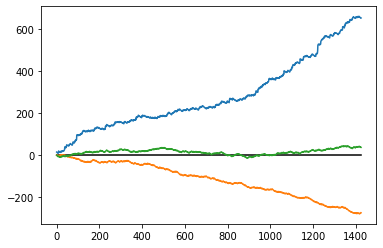

In [ ]:
comparison = data['home_comparison'].merge(data['away_comparison'], left_index = True, right_index = True)
odds = df.loc[:, ['BestH', 'BestD', 'BestA', 'BbMx>2.5', 'BbMx<2.5']]
comparison = comparison.merge(odds, how = 'left', left_index = True, right_index = True)

# Résultat
comparison['RealResult'] = ['H' if u > v else 'D' if u == v else 'A' for (u, v) in zip(comparison['home_goals_scored'], comparison['away_goals_scored'])]
comparison['PredictedResult'] = ['H' if u > v else 'D' if u == v else 'A' for (u, v) in zip(comparison['home_goals_predicted'], comparison['away_goals_predicted'])]
comparison['ProfitResult'] = [h - 1 if ((u == v) & (v == 'H')) else d - 1 if ((u == v) & (v == 'D')) else a - 1 if ((u == v) & (v == 'A')) else -1 for (u, v, h, d, a) in zip(comparison['PredictedResult'], comparison['RealResult'], comparison['BestH'], comparison['BestD'], comparison['BestA'])]
display(pd.crosstab(comparison['RealResult'], comparison['PredictedResult']))
print(f"Taux de bonne prédiction : {100 * comparison[comparison['RealResult'] == comparison['PredictedResult']].count()[0] / len(comparison): .2f}%")
print(f"Gain total : {comparison['ProfitResult'].sum():.2f}€")
print(f"Gain en pourcentage : {100 * comparison['ProfitResult'].sum() / len(comparison):.2f}%")

# Résultat
bookmaker_list = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'PSC', 'Best']
results = []

bookmaker = bookmaker_list[9]

for i in range(len(comparison)):
    if (comparison.loc[i, [bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']].min() == comparison[bookmaker + 'H'][i]) & (comparison[bookmaker + 'H'][i] == comparison[bookmaker + 'A'][i]):
        results.append('D')
    elif comparison.loc[i, [bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']].min() == comparison[bookmaker + 'H'][i]:
      results.append('H')
    elif comparison.loc[i, [bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']].min() == comparison[bookmaker + 'D'][i]:
        results.append('D')
    elif comparison.loc[i, [bookmaker + 'H', bookmaker + 'D', bookmaker + 'A']].min() == comparison[bookmaker + 'A'][i]:
        results.append('A')

comparison['OddResult'] = results
comparison['ProfitOdd'] = [h - 1 if ((u == v) & (v == 'H')) else d - 1 if ((u == v) & (v == 'D')) else a - 1 if ((u == v) & (v == 'A')) else -1 for (u, v, h, d, a) in zip(comparison['OddResult'], comparison['RealResult'], comparison['BestH'], comparison['BestD'], comparison['BestA'])]

display(pd.crosstab(comparison['RealResult'], comparison['OddResult']))
print(f"Taux de bonne prédiction : {100 * comparison[(comparison['RealResult'] == comparison['OddResult'])].count()[0] / len(comparison): .2f}%")
print(f"Gain total : {comparison['ProfitOdd'].sum():.2f}€")
print(f"Gain en pourcentage : {100 * comparison['ProfitOdd'].sum() / len(comparison):.2f}%")

#2.5 buts
comparison['RealGoal'] = ['>2.5' if u + v > 2.5 else '<2.5' for (u, v) in zip(comparison['home_goals_scored'], comparison['away_goals_scored'])]
comparison['PredictedGoal'] = ['>2.5' if u + v > 2.5 else '<2.5' for (u, v) in zip(comparison['home_goals_predicted'], comparison['away_goals_predicted'])]
comparison['ProfitGoal'] = [m - 1 if ((u == v) & (v == '>2.5')) else l - 1 if ((u == v) & (v == '<2.5')) else -1 for (u, v, l, m) in zip(comparison['PredictedGoal'], comparison['RealGoal'], comparison['BbMx<2.5'], comparison['BbMx>2.5'])]
display(pd.crosstab(comparison['RealGoal'], comparison['PredictedGoal']))
print(f"Taux de bonne prédiction : {100 * comparison[(comparison['RealGoal'] == comparison['PredictedGoal'])].count()[0] / len(comparison): .2f}%")
print(f"Gain total : {comparison['ProfitGoal'].sum():.2f}€")
print(f"Gain en pourcentage : {100 * comparison['ProfitGoal'].sum() / len(comparison):.2f}%")


#Score exact
comparison['HomeScoreline'] = [1 if u == v else 0 for (u, v) in zip(comparison['home_goals_scored'], comparison['home_goals_predicted'])]
comparison['AwayScoreline'] = [1 if u == v else 0 for (u, v) in zip(comparison['away_goals_scored'], comparison['away_goals_predicted'])]
display(pd.crosstab(comparison['HomeScoreline'], comparison['AwayScoreline']))
print(f"Taux de bonne prédiction : {100 * comparison[(comparison['HomeScoreline'] == 1) & (comparison['AwayScoreline'] == 1)].count()[0] / len(comparison): .2f}%")

plt.plot(range(len(comparison)), np.zeros(len(comparison)), color = 'black');
plt.plot(range(len(comparison)), comparison['ProfitResult'].cumsum());
plt.plot(range(len(comparison)), comparison['ProfitOdd'].cumsum());
## plt.plot(range(len(comparison.loc[comparison['PredictedResult'] != 'D',:])), comparison.loc[comparison['PredictedResult'] != 'D', 'ProfitResult'].cumsum());
plt.plot(range(len(comparison)), comparison['ProfitGoal'].cumsum());